In [1]:
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from openfermion import get_sparse_operator
import scipy as sp
from openfermion.utils import count_qubits
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from nbed.mol_plot import Draw_molecule

/home/lex/anaconda3/envs/embed/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
current_dir = os.getcwd()
structure_dir =  os.path.join(current_dir, "molecular_structures")

In [3]:
sorted(os.listdir(structure_dir))

['H4_beta_85_bottom_bottom_top_top_order.xyz',
 'H4_beta_85_bottom_top_bottom_top_order.xyz',
 'H4_beta_86_bottom_bottom_top_top_order.xyz',
 'H4_beta_86_bottom_top_bottom_top_order.xyz',
 'H4_beta_87_bottom_bottom_top_top_order.xyz',
 'H4_beta_87_bottom_top_bottom_top_order.xyz',
 'H4_beta_88_bottom_bottom_top_top_order.xyz',
 'H4_beta_88_bottom_top_bottom_top_order.xyz',
 'H4_beta_89_bottom_bottom_top_top_order.xyz',
 'H4_beta_89_bottom_top_bottom_top_order.xyz',
 'H4_beta_90_bottom_bottom_top_top_order.xyz',
 'H4_beta_90_bottom_top_bottom_top_order.xyz',
 'H4_beta_91_bottom_bottom_top_top_order.xyz',
 'H4_beta_91_bottom_top_bottom_top_order.xyz',
 'H4_beta_92_bottom_bottom_top_top_order.xyz',
 'H4_beta_92_bottom_top_bottom_top_order.xyz',
 'H4_beta_93_bottom_bottom_top_top_order.xyz',
 'H4_beta_93_bottom_top_bottom_top_order.xyz',
 'H4_beta_94_bottom_bottom_top_top_order.xyz',
 'H4_beta_94_bottom_top_bottom_top_order.xyz',
 'H4_beta_95_bottom_bottom_top_top_order.xyz',
 'H4_beta_95_

In [4]:
ending = 'bottom_top_bottom_top_order.xyz'

bottom_top_bottom_top_file_paths = []
for xyz_filename in sorted(os.listdir(structure_dir)):
    if  xyz_filename.endswith(ending):
        bottom_top_bottom_top_file_paths.append(os.path.join(structure_dir, xyz_filename))

In [5]:
file_index = 5
with open(bottom_top_bottom_top_file_paths[file_index], 'r') as infile:
    xyz = infile.read()

print('molecule: ', bottom_top_bottom_top_file_paths[file_index][-42:])
mol_viewer = Draw_molecule(xyz)
mol_viewer.show()

molecule:  H4_beta_90_bottom_top_bottom_top_order.xyz


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
basis = 'STO-3G'
xc_functional = 'B3LYP'
convergence = 1e-6
charge = 0
mu_level_shift=1e6
run_ccsd_emb = False
run_fci_emb = True
max_ram_memory = 8_000
pyscf_print_level = 1
unit = 'angstrom'
occupied_threshold = 0.95
virtual_threshold = 0.95
max_hf_cycles=10_000
transform = 'jordan_wigner'

In [7]:
n_active_atoms = 3
localization = 'ibo' #spade, ibo

projector = 'both' #'both', 'huzinaga', 'mu'
init_huzinaga_rhf_with_mu = False

In [8]:
def get_hamiltonian_from_driver(rhf_pyscf, energy_shift, qubit_transform):
    # n_qubits = 2*rhf_pyscf.mol.nao
    qham = HamiltonianBuilder(
                            scf_method=rhf_pyscf,
                            constant_e_shift=energy_shift,
                            transform=qubit_transform,
                            ).build(n_qubits=None, taper=False)
    return qham

In [9]:
global_dft_list=[]
global_fci_list=[]
global_H_diag_list=[]
global_qubit_H_length_list=[]
global_qubit_H_nqubits=[]

huz_rhf_list=[]
# huz_ccsd_list=[]
huz_fci_list=[]
huz_H_diag_list=[]
huz_qubit_H_length_list=[]
huz_H_nqubits=[]

mu_rhf_list=[]
# mu_ccsd_list=[]
mu_fci_list=[]
mu_H_diag_list=[]
mu_qubit_H_length_list=[]
mu_H_nqubits=[]
N_active_AOs = []

for geometry_path in tqdm(bottom_top_bottom_top_file_paths):
    driver = NbedDriver(
            geometry=geometry_path,
            n_active_atoms=n_active_atoms,
            basis=basis,
            xc_functional=xc_functional,
            projector=projector,
            localization=localization,
            convergence=convergence,
            charge=charge,
            mu_level_shift=mu_level_shift,
            run_ccsd_emb=run_ccsd_emb,
            run_fci_emb=run_fci_emb,
            max_ram_memory=max_ram_memory,
            pyscf_print_level=pyscf_print_level,
            unit=unit,
            occupied_threshold=occupied_threshold,
            virtual_threshold=virtual_threshold,
            max_hf_cycles=max_hf_cycles,
            _init_huzinaga_rhf_with_mu = init_huzinaga_rhf_with_mu)

    
#     print(driver.localized_system.active_MO_inds)
#     print()
    
    ## global
    global_dft_list.append(driver._global_rks.e_tot)
    global_fci_list.append(driver._global_fci.e_tot)
    
    global_qubit_Ham = get_hamiltonian_from_driver(driver._global_hf,
                                           driver._global_hf.energy_nuc(), 
                                           transform)
    
    global_H_sparse = get_sparse_operator(global_qubit_Ham)
    E_fci =  sp.sparse.linalg.eigsh(global_H_sparse, k=1, which='SA')[0][0] 
    global_H_diag_list.append(E_fci)

    global_qubit_H_length_list.append(len(global_qubit_Ham.terms))
    global_qubit_H_nqubits.append(count_qubits(global_qubit_Ham))

    ##
    N_active_AOs.append(len(driver.localized_system.active_MO_inds))
    
    # HUZ
    huz_rhf_list.append(driver._huzinaga['e_rhf'])
#     huz_ccsd_list.append(driver._huzinaga['e_ccsd'])
    huz_fci_list.append(driver._huzinaga['e_fci'])

    huz_classical = driver._huzinaga['classical_energy']
    huz_qubit_Ham = get_hamiltonian_from_driver(driver._huzinaga["scf"],
                                        huz_classical, #+ driver._huzinaga["scf"].energy_nuc(), 
                                        transform)
    
    huz_H_sparse = get_sparse_operator(huz_qubit_Ham)
    huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which='SA')[0][0]
    huz_H_diag_list.append(huz_e_emb)

    huz_qubit_H_length_list.append(len(huz_qubit_Ham.terms))
    huz_nqubits = count_qubits(huz_qubit_Ham)
    huz_H_nqubits.append(huz_nqubits)

    # mu shift
    mu_rhf_list.append(driver._mu['e_rhf'])
#     mu_ccsd_list.append(driver._mu['e_ccsd'])
    mu_fci_list.append(driver._mu['e_fci'])
    
    mu_classical = driver._mu['classical_energy']
    mu_qubit_Ham = get_hamiltonian_from_driver(driver._mu["scf"],
                                        mu_classical, #+ driver._mu["scf"].energy_nuc(), 
                                        transform)
    
    mu_H_sparse = get_sparse_operator(mu_qubit_Ham)
    mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which='SA')[0][0]
    mu_H_diag_list.append(mu_e_emb)
    
    mu_nqubits = count_qubits(huz_qubit_Ham)
    mu_qubit_H_length_list.append(len(mu_qubit_Ham.terms))
    mu_H_nqubits.append(mu_nqubits)
    
    del driver



  0%|          | 0/11 [00:00<?, ?it/s]

 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 4.79e-16
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 9.68e-16
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 5.52e-16
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 2.08e-15
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 3.09e-15
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 2.69e-13
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 2.13e-15
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 4.55e-15
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 3.54e-16
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 3.36e-15
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 1.68e-15


In [10]:
import pandas as pd
exp_data = {
    'global DFT': global_dft_list, 
    
    'global FCI': global_fci_list,
    'huz emb FCI': huz_H_diag_list,
    'mu emb FCI': mu_H_diag_list,
    
    'global H': global_qubit_H_length_list,
    'huz H emb': huz_qubit_H_length_list,
    'mu H emb': mu_qubit_H_length_list,
    
    'global n qubits ': global_qubit_H_nqubits,
    'huz n qubits ': huz_H_nqubits,
    'mu n qubits ': mu_H_nqubits,
    'N active AOs ': N_active_AOs,
    
}

df = pd.DataFrame(data=exp_data)

df

,global DFT,global FCI,huz emb FCI,mu emb FCI,global H,huz H emb,mu H emb,global n qubits,huz n qubits,mu n qubits,N active AOs
0,-1.713780,-1.875969,-1.794499,-1.794499,97,62,62,8,6,6,1
1,-1.709245,-1.875394,-1.791868,-1.791868,97,62,62,8,6,6,1
2,-1.704842,-1.874932,-1.789331,-1.789331,97,62,62,8,6,6,1
3,-1.700565,-1.874591,-1.786878,-1.786878,97,62,62,8,6,6,1
4,-1.696407,-1.874382,-1.784499,-1.784499,97,62,62,8,6,6,1
5,-1.218709,-1.874311,-1.670010,-1.670010,105,62,118,8,6,6,1
6,-1.696407,-1.874382,-1.784499,-1.784499,97,62,62,8,6,6,1
7,-1.700565,-1.874591,-1.786878,-1.786878,97,62,62,8,6,6,1
8,-1.704842,-1.874932,-1.789331,-1.789331,97,62,62,8,6,6,1
9,-1.709245,-1.875394,-1.791868,-1.791868,97,62,62,8,6,6,1


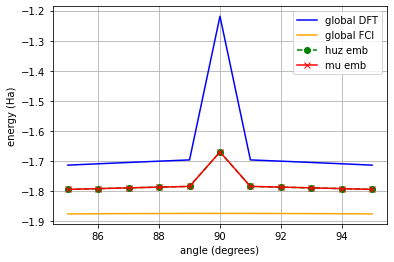

In [11]:
%matplotlib inline

angles = list(range(85,96))
# angles = list(range(85,87))

plt.plot(angles, global_dft_list, label='global DFT', color='b')
plt.plot(angles, global_fci_list, label='global FCI', color='orange')
plt.plot(angles, huz_H_diag_list, label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(angles, mu_H_diag_list, label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('angle (degrees)')
plt.ylabel('energy (Ha)')
plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()

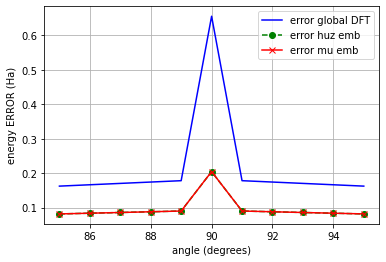

In [12]:
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(global_dft_list)), label='error global DFT', color='b')
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(huz_H_diag_list)) , label='error huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(mu_H_diag_list)) , label='error mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('angle (degrees)')
plt.ylabel('energy ERROR (Ha)')
plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()

In [13]:
ending = 'bottom_bottom_top_top_order.xyz'

bottom_bottom_top_top_file_paths = []
for xyz_filename in sorted(os.listdir(structure_dir)):
    if  xyz_filename.endswith(ending):
        bottom_bottom_top_top_file_paths.append(os.path.join(structure_dir, xyz_filename))

In [ ]:
global_dft_list=[]
global_fci_list=[]
global_H_diag_list=[]
global_qubit_H_length_list=[]
global_qubit_H_nqubits=[]

huz_rhf_list=[]
# huz_ccsd_list=[]
huz_fci_list=[]
huz_H_diag_list=[]
huz_qubit_H_length_list=[]
huz_H_nqubits=[]

mu_rhf_list=[]
# mu_ccsd_list=[]
mu_fci_list=[]
mu_H_diag_list=[]
mu_qubit_H_length_list=[]
mu_H_nqubits=[]
N_active_AOs = []

for geometry_path in tqdm(bottom_bottom_top_top_file_paths):
#     try:
    driver = NbedDriver(
            geometry=geometry_path,
            n_active_atoms=n_active_atoms,
            basis=basis,
            xc_functional=xc_functional,
            projector=projector,
            localization=localization,
            convergence=convergence,
            charge=charge,
            mu_level_shift=mu_level_shift,
            run_ccsd_emb=run_ccsd_emb,
            run_fci_emb=run_fci_emb,
            max_ram_memory=max_ram_memory,
            pyscf_print_level=pyscf_print_level,
            unit=unit,
            occupied_threshold=occupied_threshold,
            virtual_threshold=virtual_threshold,
            max_hf_cycles=max_hf_cycles,
            _init_huzinaga_rhf_with_mu = init_huzinaga_rhf_with_mu)
#     except:
#         print('error for:')
#         print(geometry_path)
#         print()
#         continue

    ## global
    global_dft_list.append(driver._global_rks.e_tot)
    global_fci_list.append(driver._global_fci.e_tot)
    
    global_qubit_Ham = get_hamiltonian_from_driver(driver._global_hf,
                                           driver._global_hf.energy_nuc(), 
                                           transform)
    
    global_H_sparse = get_sparse_operator(global_qubit_Ham)
    E_fci =  sp.sparse.linalg.eigsh(global_H_sparse, k=1, which='SA')[0][0] 
    global_H_diag_list.append(E_fci)

    global_qubit_H_length_list.append(len(global_qubit_Ham.terms))
    global_qubit_H_nqubits.append(count_qubits(global_qubit_Ham))

    ##
    N_active_AOs.append(len(driver.localized_system.active_MO_inds))
    
    # HUZ
    huz_rhf_list.append(driver._huzinaga['e_rhf'])
#     huz_ccsd_list.append(driver._huzinaga['e_ccsd'])
    huz_fci_list.append(driver._huzinaga['e_fci'])

    huz_classical = driver._huzinaga['classical_energy']
    huz_qubit_Ham = get_hamiltonian_from_driver(driver._huzinaga["scf"],
                                        huz_classical, #+ driver._huzinaga["scf"].energy_nuc(), 
                                        transform)
    
    huz_H_sparse = get_sparse_operator(huz_qubit_Ham)
    huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which='SA')[0][0]
    huz_H_diag_list.append(huz_e_emb)

    huz_qubit_H_length_list.append(len(huz_qubit_Ham.terms))
    huz_nqubits = count_qubits(huz_qubit_Ham)
    huz_H_nqubits.append(huz_nqubits)

    # mu shift
    mu_rhf_list.append(driver._mu['e_rhf'])
#     mu_ccsd_list.append(driver._mu['e_ccsd'])
    mu_fci_list.append(driver._mu['e_fci'])
    
    mu_classical = driver._mu['classical_energy']
    mu_qubit_Ham = get_hamiltonian_from_driver(driver._mu["scf"],
                                        mu_classical, #+ driver._mu["scf"].energy_nuc(), 
                                        transform)
    
    mu_H_sparse = get_sparse_operator(mu_qubit_Ham)
    mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which='SA')[0][0]
    mu_H_diag_list.append(mu_e_emb)
    
    mu_nqubits = count_qubits(huz_qubit_Ham)
    mu_qubit_H_length_list.append(len(mu_qubit_Ham.terms))
    mu_H_nqubits.append(mu_nqubits)
    
    del driver



  0%|          | 0/11 [00:00<?, ?it/s]

 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 3.75e-16
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 2.34e-15
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 2.64e-15
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 2.09e-15
 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 2.82e-15


In [ ]:
exp_data = {
    'global DFT': global_dft_list, 
    
    'global FCI': global_fci_list,
    'huz emb FCI': huz_H_diag_list,
    'mu emb FCI': mu_H_diag_list,
    
    'global H': global_qubit_H_length_list,
    'huz H emb': huz_qubit_H_length_list,
    'mu H emb': mu_qubit_H_length_list,
    
    'global n qubits ': global_qubit_H_nqubits,
    'huz n qubits ': huz_H_nqubits,
    'mu n qubits ': mu_H_nqubits,
    'N active AOs ': N_active_AOs,
    
}

df = pd.DataFrame(data=exp_data)

df

In [ ]:
%matplotlib inline

angles = list(range(85,96))
# angles = list(range(85,87))

plt.plot(angles, global_dft_list, label='global DFT', color='b')
plt.plot(angles, global_fci_list, label='global FCI', color='orange')
plt.plot(angles, huz_H_diag_list, label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(angles, mu_H_diag_list, label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('angle (degrees)')
plt.ylabel('energy (Ha)')
plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()

In [ ]:
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(global_dft_list)), label='error global DFT', color='b')
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(huz_H_diag_list)) , label='error huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(mu_H_diag_list)) , label='error mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('angle (degrees)')
plt.ylabel('energy ERROR (Ha)')
plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()